# Getting started

In [1]:
#!pip install neuralforecast

### Import libraries

In [2]:
import neuralforecast as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch as t

### Dataset

In [3]:
Y_df, X_df, _ = nf.data.datasets.long_horizon.LongHorizon.load('data', 'ILI')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
X_df['ds'] = pd.to_datetime(X_df['ds'])
Y_df.head()

,unique_id,ds,y
0,% WEIGHTED ILI,2002-01-01,-0.421499
1,% WEIGHTED ILI,2002-01-08,-0.331239
2,% WEIGHTED ILI,2002-01-15,-0.342763
3,% WEIGHTED ILI,2002-01-22,-0.199782
4,% WEIGHTED ILI,2002-01-29,-0.218426


### Split train/test sets

In [4]:
output_size = 24
Y_df_test = Y_df.groupby('unique_id').tail(output_size)
Y_df_train = Y_df.drop(Y_df_test.index)

X_df_train = X_df.drop(Y_df_test.index)

### Define WindowsDataset and TimeSeriesLoader

In [5]:
input_size = 5 * output_size

In [6]:
train_mask_df, val_mask_df, _ = nf.experiments.utils.get_mask_dfs(
    Y_df=Y_df_train,
    ds_in_val=7 * output_size,
    ds_in_test=0
)

In [7]:
plot_df = Y_df_train.merge(
    train_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_train'}),
    how='left',
    on=['unique_id', 'ds']
).merge(
    val_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_val'}),
    how='left',
    on=['unique_id', 'ds']
)

In [8]:
plot_df['y_train'] = np.where(plot_df['sample_mask_train'] == 1, plot_df['y'], np.nan)
plot_df['y_val'] = np.where(plot_df['sample_mask_val'] == 1, plot_df['y'], np.nan)

<AxesSubplot:xlabel='ds'>

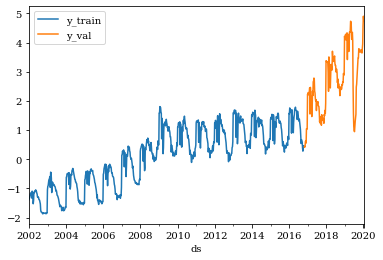

In [9]:
plot_df.query('unique_id == "OT"').set_index('ds')[['y_train', 'y_val']].plot()

### Automatic hyperparameter optimization

In [12]:
hyper_space = nf.models.nbeats.nbeats.suggested_space(
    input_size, output_size, 
    n_x=4, n_s=0, 
    frequency='W-TUE'
)

In [ ]:
trials = nf.experiments.utils.hyperopt_tunning(
    hyper_space, hyperopt_max_evals=20, 
    loss_function_val='MAE',
    loss_functions_test='MAE', 
    S_df=None,
    Y_df=Y_df_train,
    X_df=X_df_train, 
    f_cols=[f'ex_{i}' for i in range(1, 5)], 
    ds_in_val=7 * output_size,
    ds_in_test=0,
    return_forecasts=False, 
    save_progress=False, 
    results_file='hyperopt.p'
)

  0%|                                                                                                                                                                | 0/20 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011679 seconds
INFO:hyperopt.tpe:TPE using 0 trials



activation                                          ReLU                                                                                                                                                    
batch_normalization                                False
batch_size                                             1
complete_windows                                    True
dropout_prob_theta                                     0
early_stop_patience                                   10
eval_freq                                             50
frequency                                          W-TUE
idx_to_sample_freq                                     1
initialization                              lecun_normal
learning_rate                                      0.005
loss_hypar                                           0.5
loss_train                                           MAE
loss_valid                                           MAE
lr_decay                                             

INFO:root:Train Validation splits

INFO:root:                                      ds           
                                     min        max
unique_id         sample_mask                      
% WEIGHTED ILI    0           2016-11-01 2020-01-14
                  1           2002-01-01 2016-10-25
%UNWEIGHTED ILI   0           2016-11-01 2020-01-14
                  1           2002-01-01 2016-10-25
AGE 0-4           0           2016-11-01 2020-01-14
                  1           2002-01-01 2016-10-25
AGE 5-24          0           2016-11-01 2020-01-14
                  1           2002-01-01 2016-10-25
ILITOTAL          0           2016-11-01 2020-01-14
                  1           2002-01-01 2016-10-25
NUM. OF PROVIDERS 0           2016-11-01 2020-01-14
                  1           2002-01-01 2016-10-25
OT                0           2016-11-01 2020-01-14
                  1           2002-01-01 2016-10-25
INFO:root:
Total data 			6594 time stamps 
Available percentage=100.0, 

Validation sanity check: 0it [00:00, ?it/s]

/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."

/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."



Training: 0it [00:00, ?it/s]